In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np

# home brew utitilties
# import resources.sr_ut as sut
# import resources.utility_functions as ut
# import resources.chart_kwargs as ck

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

# name of the output folder:
name_of_project = 'femhygiene'

# add the folder to the directory tree:
# project_directory = ut.make_project_folder('output', name_of_project)

dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map location slug to the proper city name
city_map = dfBeaches['city']

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

## Where are you most likely to find feminine hygiene products if you are doing a litter survey in the Geneva area

### Constraints / preferences

* access with public transport

* Seeking a specific type of object (feminine hygiene products)

* preferably a place where this object has been found before

### The summary requirements

> We would prefer sites with higher possibility of finding these materials, this would be our preference above everything else

## Finding the site and predicting the outcome

We want to maximize the chances of finding the objects given the above constraints. All data from Lac Léman since 2015 will be considered

In [2]:
# all data since 2015
ldb = pd.read_csv(f"resources/fhg.csv")

# assign loc_date
ldb['loc_date'] = list(zip(ldb.location, ldb['date']))

# date to datetime
ldb['date'] = pd.to_datetime(ldb['date'], format="%Y-%m-%d")

# agg levels
samp_loc = ['loc_date', 'location']
ldate = ['loc_date']
city = ['Genève']

# agg columns
qandp = {'quantity':'sum', 'pcs_m':'sum'}
qandnsamps = {'quantity': 'sum', 'loc_date':'nunique'}

# agg codes and groups
code = ['G144', 'G96']
groupname = ['waste water']

# masks for the data:
p1 = (ldb['date']<= start_date)
p2 =(ldb['date'] >= start_date)&(ldb['date'] <= end_date)
sg = ldb.city.isin(city)
fhw = (ldb.groupname.isin(groupname))
fhg = ldb.code.isin(code)
gzero = ldb.quantity > 0

# totals for each survey
ldbdt = ldb.groupby(samp_loc, as_index=False).agg(qandp)

# map location to survey totals
ldbtqmap = ldbdt.set_index(ldate)['quantity']
ldbtpmap = ldbdt.set_index(ldate)['pcs_m']

# the survey totals in pcs_m and quantity for each survey at each location
adlt = ldb.groupby('location').agg(qandnsamps)
adlt['pcs_m_mean'] = adlt.index.map(lambda x: ldbdt.loc[ldbdt.location == x].pcs_m.mean())
adlt['pcs_m_median'] = adlt.index.map(lambda x: ldbdt.loc[ldbdt.location == x].pcs_m.median())

In [3]:
# the number of samples
nsamps = ldb.loc_date.nunique()

# the number of samples with at least one object of interest
nsampsfhg = ldb[fhg&gzero].loc_date.nunique()

# the number of samples with at least one waste water object:
nsampsww = ldb[fhw&gzero].loc_date.nunique()

# the ratio of samples with at least one waste water object with respect to all the samples
nsampsww/nsamps

0.9190283400809717

In [4]:
# the ratio of all waste water objects found to all objects found
awwt = ldb[ldb.groupname == 'waste water'].quantity.sum()
adq = ldb.quantity.sum()
awwt/adq

0.07353016490832735

In [5]:
# the ratio of samples with at least one fhg object with respect to all the samples:
nsampsfhg/nsamps

0.41295546558704455

In [6]:
# the ratio of all fhg products found to all objects found:
afhg = ldb[(ldb.code.isin(code))].quantity.sum()

afhg/adq

0.004583632080303186

In [7]:
# the quantity of objects, waste water objects and fh objects
print(adq,  awwt, afhg)

78104 5743 358


### Historical data

The first sample was recorded on Lac Léman on November 23, 2015. Between November 2015 and June 2021 there were 247 beach-litter surveys. Objects associated with water treatment plants were present in 227 samples (92%), tampon applicators and/or tampons were present in 102 samples (41%). There were 78,104 objects removed and identified, of those objects 5,743 came from waste water treatment facilities of which 358 objects were either tampons or tampon applicators. Considering all the samples on Lac Léman the probability of finding at least one tampon or applicator on a survey was 41%.

There are 38 unique sampling locations. The likelihood of finding one FH object at any individual location ranges from zero to one. In total there 9/38 locations where no FH products were identified. The summary of the results are in the table below.

_**Table of results all Léman surveys:**_ Pos samples is the number of samples at that location that were postive for FH products. The likelihood is the ratio of _pos samples_ to _samples_. The locations that have the highest likelihood of finding an FH product are not in Geneva. They are located in the region of the _Grand Lac_ and the _Haut lac_.

In [8]:
adlt.rename(columns={'loc_date':'n samples', 'quantity':'total objects'}, inplace=True)
foundfhg =ldb[fhg&gzero].groupby('location').agg({"loc_date":"nunique", "pcs_m":"mean", "quantity":"sum"})

fhg_summary = pd.concat([adlt,foundfhg], axis=1)
fhg_summary.fillna(0, inplace=True)
fhg_summary['prior'] = .41/(.41*len(fhg_summary))
fhg_summary['likelihood'] = ((fhg_summary.loc_date)/fhg_summary['n samples'])
fhg_summary['post'] = fhg_summary.prior * fhg_summary.likelihood

fhg_summary['pnorm'] = fhg_summary.post/fhg_summary.post.sum()

nested_columns = [('All objects', 'total objects'),
                  ('All objects', 'samples'),
                  ('All objects', 'average pcs/m'),
                  ('Feminine hygiene', 'pos samples'),
                  ('Feminine hygiene', 'average pcs/m'),
                  ('Feminine hygiene', 'quantity'),
                  ('Feminine hygiene', 'likelihood')
                 ]

# nest the columns for display
x = fhg_summary[['total objects', 'n samples', 'pcs_m_mean', 'loc_date','pcs_m', 'quantity', 'likelihood']].copy()
x.rename(columns={'loc_date':'with FHP', 'pcs_m': 'average pcs/m'})
x.columns = pd.MultiIndex.from_tuples(nested_columns)
x.sort_values(by=[('All objects','samples')], ascending = False)

All objects                       Feminine hygiene  \
                         total objects samples average pcs/m      pos samples   
location                                                                        
quai-maria-belgia                 8211      22      9.691364             13.0   
baye-de-montreux-g                4071      18      5.010000              2.0   
veveyse                           3436      17      3.962353              6.0   
baye-de-montreux-d                5152      16      5.385625              5.0   
maladaire                         4071      15      4.656000              3.0   
preverenges                       3679      14      6.376429              9.0   
baye-de-clarens                   2968      13      3.266154              1.0   
grand-clos                        8907      13     23.720000              9.0   
lacleman_vidy_santie              2767      12      8.556667             10.0   
lacleman_gland_kubela              574      11      7.440000              3.0   
lacleman_gland_lecoanets           910      11      1.072727              4.0   
villa-barton                      1829      11      9.474545              1.0   
baby-plage-geneva                 3275      11      3.104545              3.0   
vidy-ruines                       1000       7     19.465714              2.0   
le-pierrier                       3891       5     14.810000              3.0   
arabie                            3417       5     17.508000              2.0   
bain-des-dames                    1819       4     20.292500              3.0   
versoix                           2073       4      4.622500              1.0   
parc-des-pierrettes               1575       4      8.982500              4.0   
tiger-duck-beach                  3104       4     37.825000              3.0   
la-pecherie                        631       3      7.226667              3.0   
jardin-botanique                  1659       3      8.676667              2.0   
oyonne                            1506       3     18.680000              2.0   
plage-de-st-sulpice               3102       3     14.966667              2.0   
baby-plage-ii-geneve                88       2      0.755000              0.0   
anarchy-beach                     1119       2      9.790000              2.0   
boiron                             490       2      2.530000              0.0   
cully-plage                        121       2      5.015000              0.0   
preverenges-le-sout                268       1      2.680000              1.0   
plage-de-dorigny                   385       1      9.570000              1.0   
rocky-plage                         99       1      0.680000              0.0   
rolle-plage                        146       1      9.750000              0.0   
saint-sulpice                      147       1      8.190000              0.0   
pierrier-sud                       633       1     39.560000              0.0   
tolochenaz                         186       1      5.350000              0.0   
le-port                            570       1     33.550000              0.0   
vidy                                55       1      6.860000              1.0   
la-morges                          170       1      5.630000              1.0   

                                                            
                         average pcs/m quantity likelihood  
location                                                    
quai-maria-belgia             0.048462     23.0   0.590909  
baye-de-montreux-g            0.020000      2.0   0.111111  
veveyse                       0.055000     16.0   0.352941  
baye-de-montreux-d            0.034000     10.0   0.312500  
maladaire                     0.040000      7.0   0.200000  
preverenges                   0.051111     18.0   0.642857  
baye-de-clarens               0.040000      3.0   0.076923  
grand-clos                    0.121111     28.0   0.692308  
lacleman_vidy_santie          0.22

#### Surveys in Geneva

There were 28 surveys in Geneva, on both sides of the bay, six surveys were positive. The left bank (Eau Vives) had three positive surveys at _baby-plage-geneva_ and the stretch between Parc Barton and Jardin Botanique had three positive surveys on the right bank.

__Likelihood of finding an FH object on the beach in Geneva__

Given the previous results the likelihood of finding an FH product on the beach in Geneva is $\approx$ 21%. The best opportunity to find an FH object would be on the right bank on the stretch of Quai from Parc Barton to Jardin Botanique. The table of results below summarizes the results for all locations surveyed in Geneva.

_**Table of results Geneva surveys**_


In [9]:
# calculate the probabilities restricting the surveys to geneva
gnv = ldb[ldb.city == "Genève"].location.unique()

# fhg_summary is indexed by location
genf = fhg_summary.loc[gnv].copy()

# the prior for all the locations is the average fail rate for the region
genf['prior'] = (genf.loc_date.sum()/genf['n samples'].sum())/len(genf)
genf['likelihood'] = (genf.loc_date/genf['n samples'])
genf['post'] = genf.prior * genf.likelihood
genf['pnorm'] = genf.post/genf.post.sum()

# make a copy for display
x1=genf.copy()

# add the normalized probability 
nested_columns.append(('Feminine hygiene', 'probability'))

x1 = x1[['total objects', 'n samples', 'pcs_m_mean', 'loc_date','pcs_m', 'quantity', 'likelihood', 'pnorm']]
x1.rename(columns={'loc_date':'with FHP', 'pcs_m': 'average pcs/m', 'pnorm':'probability'}, inplace=True)
x1.columns = pd.MultiIndex.from_tuples(nested_columns)
x1.sort_values(by=[('Feminine hygiene','probability')], ascending = False)

All objects                       Feminine hygiene  \
                     total objects samples average pcs/m      pos samples   
location                                                                    
jardin-botanique              1659       3      8.676667              2.0   
baby-plage-geneva             3275      11      3.104545              3.0   
villa-barton                  1829      11      9.474545              1.0   
baby-plage-ii-geneve            88       2      0.755000              0.0   
rocky-plage                     99       1      0.680000              0.0   

                                                                    
                     average pcs/m quantity likelihood probability  
location                                                            
jardin-botanique              0.05      6.0   0.666667    0.647059  
baby-plage-geneva             0.03      6.0   0.272727    0.264706  
villa-barton                  0.08      4.0   0.090909    0.088235  
baby-plage-ii-geneve          0.00      0.0   0.000000    0.000000  
rocky-plage                   0.00      0.0   0.000000    0.000000


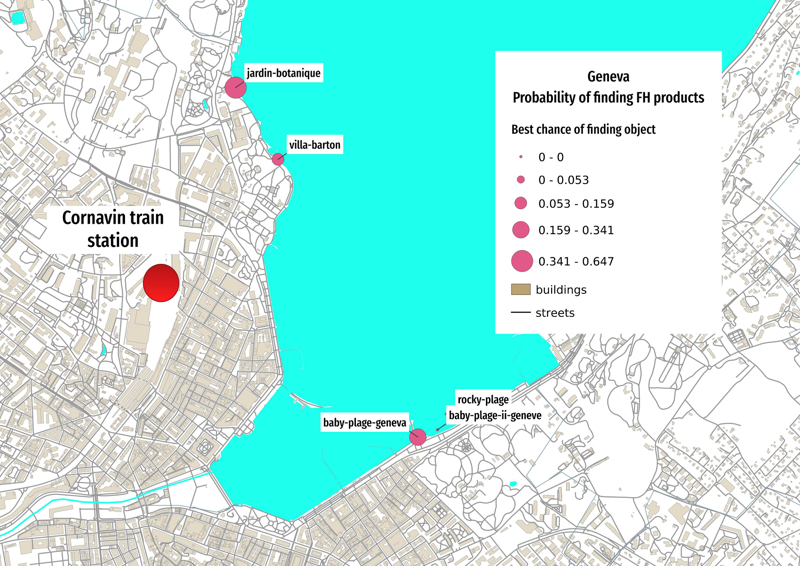

In [10]:
output = io.BytesIO()
bassin_map = PILImage.open("resources/images/locgeneve.jpeg")
bassin_map.thumbnail((800, 1200))
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

## Conclusion and notes

Public transport is available at all locations. The bay can be crossed by two different ferry services on the quai. Hopefully this service will not be needed because the object was found at the initial survey location.

If the lake level is not too high there should be enough access on the right bank to do a survey. Otherwise the beaches on the left bank are the best bet for finding exposed shoreline. However, the large public beaches are mechanically maintained. 

The simplest access from the train station is _villa-barton_ on the right bank. Upstream from there is the Jardin Botanique where the probability of finding an object is greatest.

In [11]:
# csv for qgis
locs = x1.index
glocs = dfBeaches.loc[locs][['latitude', 'longitude']].copy()
glocs['probability'] = glocs.index.map(lambda x: x1.loc[x]['Feminine hygiene']['probability'])


# glocs.reset_index(inplace=True)
# glocs.to_csv(f'{project_directory}/glocs.csv',index=False)

In [12]:
author = "roger@hammerdirt.ch"
my_message = "Love what you do. \u2764\ufe0f"
md(F"""
<br></br>
**This project was made possible by the Swiss federal office for the environment.**<br>

>{my_message}<br>

*{author}* pushed the run button on {today}.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
""")


<br></br>
**This project was made possible by the Swiss federal office for the environment.**<br>

>Love what you do. ❤️<br>

*roger@hammerdirt.ch* pushed the run button on 2021-11-08.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
